In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import qgrid
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import nltk
os.chdir(os.getcwd() + '/..')
from data_io import *
from speech import *
import time
import matplotlib.pyplot as plt
import pandas as pd

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Loading w2v window=5 dimension=100...done
Loading w2v window=5 dimension=150...done
Loading w2v window=5 dimension=200...done
Loading w2v window=10 dimension=100...done
Loading w2v window=10 dimension=150...done
Loading w2v window=10 dimension=200...done
Loading w2v window=15 dimension=100...done
Loading w2v window=15 dimension=150...done
Loading w2v window=15 dimension=200...done
Loading w2v window=20 dimension=100...done
Loading w2v window=20 dimension=150...done
Loading w2v window=20 dimension=200...done


In [19]:
PARAM_WINDOW='param_tfidf+w2vagg__w2vagg__agg__window'
PARAM_DIM='param_tfidf+w2vagg__w2vagg__agg__dim'

In [3]:
df = pd.read_csv('data/results/2021-04-13_14h12m27_tfidf+w2vagg/results_verbose.csv')
df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,param_lr__max_iter,param_lr__n_jobs,param_lr__penalty,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,86.184867,3.024632,2.146601,0.161906,30.0,balanced,200,-1,l2,...,0.438965,0.019151,3,0.998955,0.999216,0.999477,0.999739,0.999478,0.999373,0.000266
1,1,82.039431,2.774853,2.273599,0.155363,30.0,balanced,200,-1,l2,...,0.436457,0.017622,7,0.999216,0.999216,0.999216,0.999477,0.999216,0.999268,0.000105
2,2,83.043644,3.094285,2.322918,0.096825,30.0,balanced,200,-1,l2,...,0.440427,0.015880,1,0.999216,0.999216,0.999216,0.999477,0.999216,0.999268,0.000105
3,3,80.047434,3.748859,2.362939,0.258033,30.0,balanced,200,-1,l2,...,0.436668,0.016853,6,0.998955,0.999216,0.998955,0.999739,0.999478,0.999268,0.000305
4,4,76.132815,6.470788,2.367047,0.207252,30.0,balanced,200,-1,l2,...,0.437500,0.015361,4,0.999216,0.998955,0.998955,0.999477,0.999216,0.999164,0.000196
5,5,77.291007,2.482156,2.486115,0.173068,30.0,balanced,200,-1,l2,...,0.437083,0.014555,5,0.999216,0.998955,0.998955,0.999477,0.999216,0.999164,0.000196
6,6,77.889108,5.016382,2.523017,0.122951,30.0,balanced,200,-1,l2,...,0.430815,0.016966,9,0.998955,0.999216,0.999216,0.999739,0.999478,0.999321,0.000266
7,7,77.677237,3.983504,2.636401,0.145342,30.0,balanced,200,-1,l2,...,0.436247,0.015423,8,0.999216,0.998955,0.999216,0.999477,0.999216,0.999216,0.000165
8,8,70.809832,4.576880,2.389733,0.388216,30.0,balanced,200,-1,l2,...,0.439801,0.015552,2,0.998955,0.998955,0.998955,0.999477,0.999216,0.999112,0.000209


In [25]:
x = df[[PARAM_WINDOW, PARAM_DIM, 'mean_test_score']].set_index([PARAM_WINDOW, PARAM_DIM])
x

,,mean_test_score
param_tfidf+w2vagg__w2vagg__agg__window,param_tfidf+w2vagg__w2vagg__agg__dim,
5,100,0.438965
10,100,0.436457
15,100,0.440427
5,150,0.436668
10,150,0.437500
15,150,0.437083
5,200,0.430815
10,200,0.436247
15,200,0.439801


In [62]:
pd.DataFrame(val, index=windows, columns=dims)

,100,150,200
5,0.438965,0.436668,0.430815
10,0.436457,0.437500,0.436247
15,0.440427,0.437083,0.439801


In [65]:
val

array([[0.4389646 , 0.43666772, 0.43081478],
       [0.43645654, 0.43750038, 0.43624734],
       [0.44042685, 0.43708328, 0.43980054]])

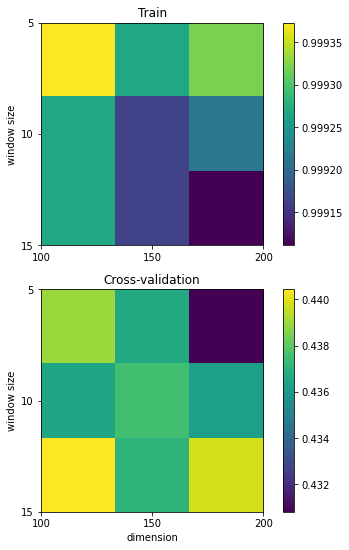

In [84]:
windows = [5, 10, 15]
dims = [100, 150, 200]

train = np.zeros((len(windows), len(dims)))
for i, w in enumerate(windows):
    for j, d in enumerate(dims):
        train[i,j] = df[(df[PARAM_DIM] == d) & (df[PARAM_WINDOW] == w)]['mean_train_score'].values[0]
val = np.zeros((len(windows), len(dims)))
for i, w in enumerate(windows):
    for j, d in enumerate(dims):
        val[i,j] = df[(df[PARAM_DIM] == d) & (df[PARAM_WINDOW] == w)]['mean_test_score'].values[0]

# train = pd.DataFrame(train, index=windows, columns=dims)
fig, axs = plt.subplots(2, 1, figsize=(7,9))

im = axs[0].imshow(train,
                   aspect=10,
                   extent=[min(dims), max(dims), max(windows), min(windows)])
axs[0].set_xticks(dims)
axs[0].set_xticklabels(dims)
axs[0].set_yticks(windows)
axs[0].set_yticklabels(windows)
fig.colorbar(im, ax=axs[0])
axs[0].set_title('Train')
# axs[0].set_xlabel('dimension')
axs[0].set_ylabel('window size')

im = axs[1].imshow(val,
                   aspect=10,
                   extent=[min(dims), max(dims), max(windows), min(windows)])
axs[1].set_xticks(dims)
axs[1].set_xticklabels(dims)
axs[1].set_yticks(windows)
axs[1].set_yticklabels(windows)
axs[1].set_title('Cross-validation')
axs[1].set_xlabel('dimension')
axs[1].set_ylabel('window size')
fig.colorbar(im, ax=axs[1])

([<matplotlib.axis.XTick at 0x12c2ec460>,
 [Text(0, 0, 'A'), Text(1, 0, 'Big'), Text(2, 0, 'Cat')])

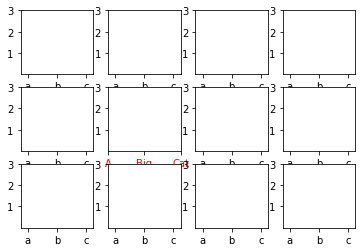

In [35]:
windows = [5, 10, 15]
dims = [100, 150, 200]

train = np.zeros((len(windows), len(dims)))
for i, w in enumerate(windows):
    for j, d in enumerate(dims):
        train[i,j] = df[(df[PARAM_DIM] == d) & (df[PARAM_WINDOW] == w)]['mean_train_score'].values[0]
val = np.zeros((len(windows), len(dims)))
for i, w in enumerate(windows):
    for j, d in enumerate(dims):
        val[i,j] = df[(df[PARAM_DIM] == d) & (df[PARAM_WINDOW] == w)]['mean_test_score'].values[0]

# train = pd.DataFrame(train, index=windows, columns=dims)
fig, axs = plt.subplots(2, 1, figsize=(5,10))

im = axs[0].imshow(train,
                   aspect=10,
                   extent=[min(dims), max(dims), max(windows), min(windows)])
axs[0].set_xticks(dims)
axs[0].set_xticklabels(dims)
axs[0].set_yticks(windows)
axs[0].set_yticklabels(windows)
fig.colorbar(im, ax=axs[0])
axs[0].set_title('Train')

im = axs[1].imshow(val,
                   aspect=10,
                   extent=[min(dims), max(dims), max(windows), min(windows)])
axs[1].set_xticks(dims)
axs[1].set_xticklabels(dims)
axs[1].set_yticks(windows)
axs[1].set_yticklabels(windows)
axs[1].set_title('Cross-validation')
fig.colorbar(im, ax=axs[1])